In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
from time import time
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from scipy.stats import power_divergence


mag_v_sun = -26.72              #Sun's V magnitude of Gaia   Jordi et al. 2010

## Definition functions

### Model Magnitud

In [2]:
def model_magnitud(theta, data):
    """
	    input:
	    theta: dataframe with parameters to estimate
	    data: dataframe with the real sample
	
	    output: dataframe with model
	"""
    mag_v_sun = -26.72

    phase_angle = data['solar_phase_angle']
    range_sat = data['range_sat']
    cross_section = theta['cross_section']
    albedo = theta['albedo'] 
    mix_coef = theta['mix_coef']

   # Change degrees to radian
    degtorad = lambda x : x*np.pi/180.

   # Definition coefficients of equation
    coe_1 = 2/(3*np.pi)
    coe_2 = 1/(4*np.pi)

    phase_angle_rad = degtorad(phase_angle)	

   
    part1 = (coe_1 *((np.pi - phase_angle_rad)*np.cos(phase_angle_rad) - np.sin(phase_angle_rad))) - coe_2
   
    model_value = mag_v_sun - 2.5 * np.log10(cross_section * albedo * (mix_coef * part1) + coe_2) + 5*np.log10(range_sat)
    
    frame = {'model_value': model_value}
    model_value_est = pd.DataFrame(frame)


    return model_value_est

### Sum Square

In [3]:
def sum_squares(theta, data):

    model_value = model_magnitud(theta, data).model_value
    rest = (data['mag_observation'] + data['e_mag']) + model_value
    residual = (rest ** 2).sum(axis=0)/(data.shape[0] - theta.shape[1])
    estimator = [residual, rest]
    
    return estimator

In [ ]:
def chi_square(theta, data):

    model_value = model_magnitud(theta, data).model_value
    rest = (data['mag_observation'] + data['e_mag']) + model_value
    print(rest[50])
    fract = ((rest ** 2) / data['mag_observation'].shape[0])
    estimator = np.sqrt(fract.sum(axis=0))
    chi_estimator = [estimator, rest]
    print(fract, chi_estimator[0])
    return chi_estimator


### Markov Chains

In [15]:
def markov_chains(init_point, std_point, size_chain):
    
    chain = np.random.normal(init_point, std_point, size_chain).round(3)
    
    return chain

### Beta distribution

In [ ]:
def beta(x):
    sample_beta = stats.beta(1,1)
    r = sample_beta.rvs(x)
    return r

### Read Data

#### PC

In [5]:
path = '/home/kero/Documents/PhD/Re-analyse/result_analyse.csv'
# path = '/home/kero/Documents/PhD/monte_carlo/result_analyse.csv'

data_sat = pd.read_csv(path)

data_in = pd.DataFrame()
data_in['solar_phase_angle'] = data_sat['obs_phase_angle']
data_in['range_sat'] = data_sat['range_sat']
data_in['mag_observation'] = data_sat['mag_observation']
data_in['e_mag'] = data_sat['mag_observation_e']
data_in.shape

(278, 4)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(x="solar_phase_angle", y="mag_observation", data=data_in)
ax.set_ylim(17, 4)
plt.show()

#### Laptop

In [ ]:
path = '/home/kero/Documents/PhD/re-analyse/test.csv'

data_sat = pd.read_csv(path)
data_in = pd.DataFrame()
data_in['solar_phase_angle'] = data_sat['SunPhaseAng']
data_in['range_sat'] = data_sat['ObsTrailLength']
data_in['mag_observation'] = data_sat['ObsMag']
data_in['e_mag'] = data_sat['e_ObsMag']

### Markov chain Monte Carlo

In [20]:
p_value = 1.3
num_simulations = 5000

good_p_value = []
mixing_coeffient_est = []
albedo_est = []
cross_section_est = []

mix_init_point = 0.75
mix_std_point = 0.12
cross_init_point = 0.8
cross_std_point = 0.35
albedo_init_point = 0.55
albedo_std_point = 0.2

size_chain_in = 1000

for i in range(num_simulations):
    mix_coef_markov = markov_chains(mix_init_point, mix_std_point, size_chain_in)
    albedo_markov = markov_chains(albedo_init_point, albedo_std_point, size_chain_in)
    cross_section_markov = markov_chains(cross_init_point, cross_std_point, size_chain_in)

    mix_coef = np.random.choice(mix_coef_markov)
    albedo = np.random.choice(albedo_markov)
    cross_section = np.random.choice(cross_section_markov)

    parameters = pd.DataFrame(data={'mix_coef': mix_coef,
                            'albedo': albedo,
                            'cross_section' : cross_section},
                            index=range(data_in.shape[0]))

    model_value = model_magnitud(parameters, data_in)

    estimador = sum_squares(parameters, data_in)
    # good_p_value.append(p_value)
    
    print(estimador[0])
    # print(estimador)
    if (estimador[0] < p_value) and (cross_section > 0.5): # and (albedo > 0.) and (cross_section > 0.5):
        p_value = estimador[0]
        good_p_value.append(p_value)
        mixing_coeffient_est.append(mix_coef)
        albedo_est.append(albedo)
        cross_section_est.append(cross_section)

        mix_init_point = mix_coef
        albedo_init_point = albedo
        cross_init_point = cross_section

        print(estimador[0])
        print('mixing_coeffient= ', mix_coef)
        print('albedo= ', albedo)
        print('cross_section= ', cross_section)
        # print('model_value= ', model_value[1])
        # print('mag_obs= ', data_in.mag_observation[1])
        print('============================================')


result_fit = pd.DataFrame(index=range(len(mixing_coeffient_est)), data={
                                                    'p_value': good_p_value,
                                                    'mixing_coeffient_est': mixing_coeffient_est,
                                                    'albedo_est': albedo_est,
                                                    'cross_section_est' : cross_section_est})



2.2607016075054576
1.3293496135050555
1.5538439794784173
1.6971198777520495
1.4552067816754735
1.500478981086452
2.515645525568046
2.1630894280879294
1.337103448685879
1.7492743746106327
1.6659807614800572
1.541924519462583
2.4460105244427774
1.6033132617490153
1.325824869839341
1.4860696422563222
1.557225753856257
1.2965250458210809
1.5490054402404376
1.3108927969084174
1.5587948012211228
1.4036238517039945
1.5928433815380054
1.4100200849711155
1.30322262356637
2.542223725627681
2.883052790507269
2.3439142227654686
2.0798971172738896
1.3120503501427285
2.003173864252337
1.6754463407421898
1.3392021070345725
1.7361827690748128
1.3053626568638748
1.6416478501294047
1.5485519491663613
1.9229900406525868
1.7335270563016674
2.1511976352740243
1.7939809950835934
1.8666489499094536
2.5370740548323507
1.577856019450098
1.5738831323626865
1.8584329764408678
1.5396984810984482
1.476930020111629
1.759460859998588
2.242965412685124
1.4612913433576669
1.8875772117129512
1.840303632510904
1.4796716

/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


1.2961775396228692
1.3039571937396606
1.224869341559336
1.223949880622948
1.2380762474804115
1.2315800419712604
1.2225712912057007
1.2225712912057007
mixing_coeffient=  0.338
albedo=  0.146
cross_section=  0.701
1.229081737392079
1.2225716171322403
1.2358322564610142
1.2593540748389425
1.2540812791739675
1.5801322912036972
1.2226206680022973
1.3429718173709526
1.2774477351124867
1.2277643406032717
1.2416880939042039
1.2405207819080624
1.2283739265231717
1.2233425283639492
1.222579088576794
1.2340954657868861
1.285237464602059
1.2232341157813829
1.263792373804594
1.2225758791415928
1.2683461983833617
1.9367424210707882
1.2307037047725775
1.2372244169074817
1.240094305859757
1.2364041242993071
1.2243320765788381
1.2538788824438494
1.2319772289141477
1.2241241858417435
1.2752541336407646
1.2505586644890343
1.2324831297748737
1.2225406883963874
1.2488273403986476
1.2382029653613411
1.2248175113110387
1.222744750851767
1.2283247572437996
1.2613995722527764
1.2277766334320306
1.2380815826574

/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


1.3066177746017356
1.2411170340385544
1.2247853735426475
1.2776197402858456
1.2226425858637375
1.260017063165753
1.2323144508964499
1.2225502450168546
1.2297553458824657
1.2666891783944159
1.2315349126212292
1.2291467509558487
1.4031370100350637
1.2338195003151382
1.269976918154314
1.223190894147486
1.2242802250200582
1.2239603070000487
1.2424157401881895
1.2384961860222488
1.2256222218756536
1.225799157055359
1.223640079353716
1.242177474936974
1.2234538049365364
1.2345012690311161
1.2268708392227017
1.2242860630043464
1.2471206459444024
1.4339026530821688
1.2365294313503727
1.223492734902194
1.2807892711552271
1.386282530231012
1.2386991792100923
1.2231415951517095
1.2390070169563003
1.2551587027773528
1.223896189766872
1.2330688415449949
1.228145428861402
1.2228987519057672
1.2670259833780668
1.2344107207271107
1.236053794895003
1.2250976993492164
1.2436833336041209
1.2227502358298385
1.225643825550052
1.2369242570100587
1.222690379742248
1.2452469923274774
1.2385182309637721
1.2282

/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


1.2331148531063278
1.2417945326831623
1.2460236110298502
1.3689994987306822
1.257796836413941
1.2235643377406076
1.3096420224691783
1.2286010052025524
1.2260422378565115
1.2294984602189953
1.3353190611576313
1.2334748142831256
1.2480197294421516
1.2303913096204206
1.2235882564027734
1.2255855090772754
1.2297853284224853
1.234291037907146
1.2352406354543273
1.2513840749719747
1.232906824971188
1.253377743951502
1.383376066294586
1.2285662353345153
1.3426405549978149
1.2611489381432512
1.333706175658889
1.2291519954550698
1.2577242139524536
1.2375815201452525
1.2335892997231208
1.2401829702285168
1.2433706425799578
1.2320008982904
1.3195338783746764
1.2253828601932517
1.2225849108445375
1.5632855619423023
1.2383817037390537
1.2233366676769255
1.2378786698612092
1.2656414018496391
1.6393878998752622
1.2226011985588676
1.2402540942711875
1.2364613892447274
1.223385461187364
1.2984499696932472
1.2303456257303862
1.2434692672426892
1.445373546664591
1.2489214755665428
1.292068828613466
1.240

/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


1.6252299847466558
1.2253475038964772
1.2225531232859501
1.3023428924976725
1.2279357017638495
1.295472240951651
1.2981441518917218
1.3017079572176464
1.229906039336836
1.2323290246830716
1.238090969060444
1.2265740658413362
1.299025740053951
1.2268771336535615
1.2366465872767665
1.3166191366975757
1.3191165650416083
1.2312309097639118
1.225889731115747
1.223853349219343
1.322453014338825
1.393955250010717
1.228679896146733
1.234836616272542
1.237760154070592
1.224289074403406
1.2432099692095637
1.2333657988861484
1.22488764757965
1.2405045899598637
1.2278484191038181
2.808193441476916
1.2244643188679971
1.2600255409476473
1.2597451441306264
1.242016989392317
1.4991134676085789
1.2293333737137917
1.2237973288070527
1.2255946226587373
1.2326584869277133
1.2439576357582527
1.2445009481875875
1.2407442718458475
1.2270574424474905
1.2291640760289804
1.2240387349182968
1.8038713824375026
1.442738408293375
1.2229963771906334
1.2225431807450335
1.291877938589949
1.223444788611101
1.2225529342

/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


1.2303364682266151
1.290727760143318
1.3665302884539
1.431129055868648
1.2446895854226
1.5398900827873114
1.2597100239414014
1.27898378357154
1.4985820245909967
1.2425940266856499
1.2542757443515706
1.222982361451875
1.6066463993815614
1.2293105032129754
1.2230011589643772
1.2277765881088143
1.278567703718914
1.226113187509385
1.2714135522988756
1.228621219535456
1.244093741328131
1.2315133503946458
1.2763675316096934
1.4001085168639351
1.2227793621168352
1.257930430975073
1.2233818740171054
1.2635389698532866
1.2260233708299566
1.444420819184095
1.2225462935937421
1.3015950846661468
1.2554361334682616
1.4632409780505917
1.226464036060724
1.4047786406865832
1.5398200821361314
1.2400926785454283
1.2227572552554777
1.6528853561205787
1.2225438568021256
1.2505672249507287
1.2316595299496695
1.2306437300285726
1.2341686691846778
1.222656483796083
1.2245995633860383
1.3416272795209792
1.323909280857759
1.4326189544353316
1.222588262146
1.2820671800462282
1.3082931699079243
1.305290713458758

/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


1.222557634989975
1.248528811589813
1.3239421427803508
1.2251176316148165
1.246268531157655
1.2285646552616296
1.2392696430888785
1.222891498849102
1.748023532175219
1.3193531060801298
1.237111413918401
1.2534191470880311
1.2243959445293255
1.2236933599064503
1.3174764901073124
1.224022700648906
1.2525290413686636
1.2391599006325453
1.222670398015901
1.2237417660495369
1.2457366524146507
1.285226604519572
1.2256094722045547
1.2306457248505385
1.2238195817331963
1.2261452953254448
1.226912822469173
1.2267982942588784
1.2945128344035466
1.3461428974536664
1.2226010049800582
1.2477268362968152
1.2442737586939845
1.243799788684591
1.25579095320688
1.3052437369563052
1.2813609723823587
1.244733640694885
1.2298690126359946
1.222910130755019
2.9036820663369944
1.276257046590261
1.3217633110957838
1.2336459135003661
1.346188860712818
1.2440149727723546
1.2381451199948306
1.309555317074499
1.2318024474686387
1.2238662524370785
1.466295756808119
1.2391657151507827
1.5860411892614787
1.2328815053

/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


1.424867624882255
1.2329171457960124
1.2360083160912279
1.3037128710123496
1.2293934099779853
1.225844492774935
1.224000099207718
1.227574917979629
1.2478802625117884
1.245221950439692
1.2324282251425607
1.236940283969571
2.6655909555211164
1.3115863400581413
1.2390754286843089
1.2298954399688549
1.2434869901604397
1.2485850016135682
1.2341065442537584
1.4372274384056114
1.2311228892391268
1.2344474261498752
1.2319036312520348
1.602998558962617
1.2421929863783738
1.222667903487937
1.3993365307493537
1.2229306536592097
1.2515219790404226
1.2475005118771147
1.2445362504409252
1.2334801771693464
1.23469750380529
1.2508985331854443
1.2627238480457696
1.2227718925520359
1.2453680746600384
1.3265386376471953
1.233482663273229
1.2600671471025309
1.2230682475328816
1.2226814589188146
1.2234934992470525
1.325609964687697
1.2265311292546404
1.2225798090492266
1.2267467507748475
1.2436079211202593
1.2369388742374787
1.2277687911324797
1.2296764969519363
1.255061947483011
1.2225528001212966
1.7741

/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


1.331974656970471
1.2353594484255948
1.2225413002784526
1.2275814695354943
1.2237452817080914
1.3272033726216192
1.2385559346911639
1.2272781103783044
1.2659430921356505
1.223526689091992
1.2225898895743148
1.2331231488888306
1.3124134759097417
1.2375877707789316
1.6652775510771693
1.225416761750723
1.2583767135545614
1.2263673515387217
1.3494557174680726
1.3100747290962382
1.2303497176547074
1.2225554618866457
1.239644537077809
1.2496786697284408
1.266311358664205
1.2610120122932644
1.4217352851608331
1.224116352386632
1.2483257221702733
1.2429668556695481
1.2299655617405032
1.2226724807110094
1.2341443536736831
1.2854372295704652
1.224043114577842
1.2339817121806234
1.458683207768283
1.2230141105323422
1.4638533545215267
1.2299388537501068
1.224983694887571
1.4596824707214653
1.254453587143981
1.5276549403763944
1.5213655966318902
1.244029063133163
1.260613280555278
1.2226116244358833
1.2358228468525312
1.2238929421224252
1.2228371263043978
1.2322777720728084
1.2292666702804933
1.222

/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


1.235582487831612
1.2322347059508159
1.4721572895605681
1.2227252610956199
1.2512843128146356
1.2239885822523608
1.2337106939000453
1.266228977484713
1.2234030257009176
1.3576481975251251
1.3404585108509737
1.2310991546162826
1.232620424190729
1.226754580547869
1.2344543016043235
1.3551962175789198
1.4324678983576533
1.2259552745413198
1.222546041118864
1.2361892156858056
3.20091859232547
1.3214277001325254
1.2237047631267413
1.2294562043849535
1.235563138040023
1.2557967048224916
1.277767849518451
1.2227256144731093
1.541812753712512
1.2358803525126028
1.2950036441340163
1.26160909537546
1.2452783541206103
1.2277965486319873
1.23755954708695
1.3099877620089206
1.2306438399478234
1.241262633920554
1.3350037297498538
1.3152174604683942
1.4407595298157407
1.2464512628231255
1.244430306014173
1.2379784795292383
1.2372080016037406
1.2230036413324379
1.328896593813979
1.3325315375839848
1.2417276313226981
1.3668124520011773
1.2248035064072613
1.3344791965602756
1.2366355957595996
1.38166486

/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


1.2719877121251613
1.2366752549377686
1.2813363988378301
1.2230157838851623
1.231901909333013
1.2300682467209971
1.2354529501506173
1.2226422269952586
1.3497849143851153
1.2513804266802693
1.2440719434421394
1.2353384171972834
1.2227491565472903
1.241806376516028
1.2376400231620415
1.2225422746162296
1.4320403344003916
1.3203618642766017
1.487728220918251
1.2326036353080234
1.305004566456107
1.3743839183144597
1.2684842593537213
1.2233654368960383
1.2760811121207793
1.2813593127560423
1.2924858055375625
1.2536739382287292
1.2232308124754576
1.2428071900947344
1.2345865015243775
1.2243420350960172
1.2398494850856094
1.2225605145183802
1.3727576983771543
1.2242385036859078
1.2229712032722675
1.2460995338231213
1.2388024008143137
1.2226244176834835
1.2228982416401661
1.2298490475046773
1.2435057703177337
1.317698593786912
1.2249819635093864
1.3133569553676774
1.2379402493170286
1.375188643373137
1.2342878664302044
1.2871865531267823
1.2275251615994593
1.421597963471296
1.727216467188717
1

/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


1.2245348908006775
1.273062912285838
1.3112102317466587
1.2289579217907882
1.272313230946272
1.2263968201732642
1.2225736975623773
1.326561041714539
1.2234284625037521
1.2644268626124233
1.2274727859285088
1.2357529082436232
1.379970339352218
1.2272759305016876
1.2676241267385984
1.2360012850250068
1.2241210970105432
2.5535051107885036
1.2884099658761474
1.2320692824917683
1.320099278903776
1.2300069722360174
1.2411123110955524
1.2249458460195415
1.3336030310664253
1.305201185396469
1.2342815745184805
1.2298250123612584
1.2281914282389859
1.2930814094529615
1.228376378546115
1.2510587471502097
1.239943908868661
1.9698926525667917
1.2308490716522758
1.522592542388962
1.2443950545484126
1.2406501574481348
1.2890175405116804
1.3059657648844434
1.2241393420667142
1.243481554523909
1.424613804201229
1.7266228665613852
1.2932651116044152
1.2362491182421904
1.2233527092170733
1.2228560371654174
1.2246609983479608
1.3248909426767574
1.282812445953895
1.2225593502086023
1.2517475827900277
1.223

/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


1.2310872054961948
1.2255492705787265
1.2812713302317356
1.2317794764915633
1.2239018578856775
1.2340397413591446
1.2240254513201725
1.6443514094720213
1.2584430131070814
1.2625550936500067
1.2296511911177066
1.2905655310418203
1.2487654477150694
1.245327743369684
1.5615863078284278
1.2251483680623672
1.2417323280931405
1.2607943037724036
1.2685081221312073
1.2733933709479333
1.2366701688080899
1.250545663198869
1.2225890682632097
1.2229102919222388
1.2419385275963257
1.4442454762528165
1.22960492517421
1.2345726628710572
1.4109167935135618
2.6448108470667897
1.2241316648948997
1.2298652977391553
1.2713765509819528
1.414042730013934
1.263097318817464
1.297459946918445
1.3768187678528534
1.3209340914405383
1.2429633831760607
1.2285580861121916
1.2227416145062244
1.2229905364674727
1.2659128481498731
1.2342029669542358
1.2422204442944298
1.2241339092432741
1.2242309010262236
1.2238794497453482
1.2229310130639792
1.3569924224888645
1.2466377741231451
1.2880933816351998
1.2230139227880814


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


1.2414341398419446
1.3500204144360235
1.3594148811802036
1.2277200888345905
1.3729993195179693
1.223249880756817
1.228317904746691
1.27295343659014
1.3577609546800138
1.304817805902168
1.2689548257138317
1.3196455104857356
1.2282344434491725
1.2490900227319839
1.2255937870996492
1.2424518331240437
1.3105243117219278
1.2347748829155625
1.2241054354821677
1.3663071209137767
1.320581174877295
1.2244737849125547
1.2318331338864292
1.2268266448282048
1.2452859810766908
1.229065107230327
1.272211534129437
2.261467063254292
1.3038540962669314
1.2225403963308719
1.2687945976275572
1.2567400047377544
1.5847256669128658
1.2624878707352651
1.261565369289379
1.2504520799228962
1.2880232159074507
1.2717995656475078
1.237343004196141
1.230528585988412
1.2264320169732277
1.460658297149448
1.2439164769910092
1.295047060786348
1.2232556434423079
1.2387845849175412
1.2904405642145023
1.3126974676154115
1.2310810748138903
1.2242109071802474
1.286593459724244
1.231503530916405
1.3123598445010385
1.2264488

/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


1.2249637654529066
1.2226718171776476
1.2305366951456378
1.2454237849079164
1.2225872400648583
1.2344915346889889
1.2832641550463124
1.2551135926660526
1.2296553934451528
1.229702875920785
1.231155295059349
1.3541837179792182
1.250823627957218
1.301903248890567
1.235070328491719
1.226198393587701
1.2457002832182016
1.234960114896365
1.2243593028043245
1.2371109599932342
1.222691225161211
1.3039092899011373
1.2320150194518447
1.2913742754373665
1.2733721536886762
1.2464203404125331
1.241409652976933
1.2483152041279337
1.2448604752778551
1.222550576187926
1.2497721666080637
1.2227012700410105
1.4126344444577383
1.2728215840507715
1.231133293807772
1.226850484591626
1.2237560704826391
1.223600750679304
1.2247073589442592
1.2554853734815523
1.2261821519188396
1.2229865939489029
1.2238189704297866
1.242012585596149
1.2234909803015968
1.2476760348340625
1.228590556753186
1.231455895329195
1.2257571206859454
1.2604446576766868
1.247041806990311
1.2536740002744169
1.2878547826006603
1.24266188

/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


1.3817303026588394
1.5730260378649858
1.236781716482299
1.2376311541695153
1.2368949889460257
1.2632917514032673
1.3800890225003968
2.792815855435438
1.2535251121294475
1.2755803809871498
1.2719104403219568
1.228520601632943
1.3970820791046161
1.2391914679835538
1.2686448044407557
1.8252229072573134
1.232463821354585
1.225381752434638
1.5447395711837622
1.2257941855814638
1.316104816921868
1.2362256373296123
1.2370500640109325
1.271439087843997
1.3019060570720908
1.2389054876223524
1.2239384788646925
1.2919543783345129
1.2241187181810669
1.227489396762087
1.2852348460501506
1.256522061410592
1.256171061407316
1.2710507662448123
1.230243429680622
1.2850492646235319
1.2682023140397545
1.226101952857584
1.2396804670667922
1.3174675512945895
1.230529266894973
1.2329880174615986
1.2435533012190645
1.2305376421898977
1.2297590617626308
1.2266104492328862
1.2861767076427486
1.2627695069072165
1.2626060104429555
1.2325780369193275
1.2386398448381604
1.274159100343271
1.2847264036089172
1.22668

/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


1.227622803496014
1.2926647491690157
1.231381922282948
1.3927015414983108
1.3944046279708318
1.2594844310346085
1.2642173922434954
1.2544588248613084
1.2256627232903177
1.2342529724278657
1.2533751395023398
1.3068390629938935
1.2248007538616599
1.2324081868101724
1.3171498086004545
1.2260814137048845
1.2458963875428906
1.2606993812348994
1.2235600617682143
1.2390524159336374
1.2394789418808867
1.226681186140998
1.3077318866230938
1.3417025517114918
1.2504225420236832
1.2569413144423027
1.2242726483933153
1.227226133041999
1.3393729058495456
1.2419005037693638
1.3435284102418954
1.2396081332581572
1.2374111150969733
1.2337155967846187
1.2232373902049378
1.2355582755307128
1.2236210722003624
1.3288867405258613
1.23389221145652
1.224560990209019
1.2679847892166531
1.229413524918415
1.2301617407781635
1.2274457657692044
1.2281235563916308
1.2514201740028685
1.242049381554273
1.259805209395215
1.223560788940144
1.2277018353029385
1.241186150549389
1.2401074418598947
1.222540951017834
1.2226

/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


1.2245393115004153
1.3875457157263942
1.2231832579653803
1.2703376688308308
1.254237401596598
1.224100414415803
1.3072281174493374
1.2287578776669679
1.2268984536682583
1.240824864212893
1.2983780794520845
1.241931891752431
1.3261650578251527
1.2289623877136655
1.4163185471856703
1.2743792875332496
1.2352187960663197
1.2225561750055947
1.2225589735108084
1.2460722442393821
1.2230254896962252
1.3129498638362966
1.2230232192127892
1.2268142440673342
1.2637431002850914
1.2888265988163803
1.2266414593155797
1.4999619662188566
1.2230394417201138
1.232338443769161
1.292418544208702
1.9346219725525424
1.2235763369889407
1.232848027221798
1.2268134005752178
1.2420058761361232
1.2301906137134933
1.230182116385811
1.2231922477631691
1.277885028966454
1.2226819093843349
1.2225428756693986
1.2245589541547717
1.2417234709577327
1.2763132228468492
1.2238609556313012
1.227581618850653
1.2622758738047353
1.2815270842573763
1.2233635521807045
1.2630214138573417
1.4169988335804926
1.283322997846612
1.40

/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


1.283368075279434
1.2713882129838576
1.225645633651249
1.2429996285429183
1.2251385496201204
1.3222158315136303
1.2225857832465532
1.2470543128461016
2.8691739600255217
1.231530604911106
1.2240413113265645
1.2903490623534113
1.2440845324275218
1.2396340104549872
1.2749174231904528
1.2474069879813119
1.2675874137731096
1.2262658595121985
1.2230609326865836
1.2297099218574183
1.2507786287866736
1.3078249762735685
1.2449006913071625
1.2245550433487356
1.2460934018256276
1.2444910831518623
1.2383604832877673
1.2231135496313725
1.2246372735581132
1.238641798179553
1.2230888908041706
1.4101472709147695
1.2228681422062757
1.2415428968776485
1.2348217793798073
1.2235717770756747
1.2390744016013744
1.2701571020921203
1.2399923642967436
1.2371767716873552
1.242924743129775
1.4490726478930847
1.2481105122508254
1.229845004783556
1.2241215579341307
1.3234278335166032
1.2278421236108332
2.8125533166365124
1.2370369865827433
1.2306377231043593
1.23520724032007
1.2522474726754629
1.330068955240617
1.

/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


1.2953213705110882
1.2227402188928473
1.254391242891291
1.2260157687183568
1.4923679469121698
1.2225665152386263
1.2309852565664219
1.2563054138287637
1.281043505871693
1.2385816490795245
1.2890887444532784
1.28414004556775
1.2308107554167846
1.2451294753965105
1.2457954433272516
1.2593957805028717
1.2398619772634312
1.3507348245719981
1.4706996904426788
1.49165989856317
1.2407227368623965
1.2298748786990477
1.22949581673962
1.2678649796256527
1.2298450325610961
1.2331208973055778
1.2292360757275596
1.2343300260203607
1.2384223590403236
1.2937696789703534
1.3559175366025042
1.2363857702896046
1.3008013279716402
1.3043921492845965
1.2355412854140042
1.2241985354265732
1.222710091517984
1.2936351452347927
1.2542651625581127
1.4284644978377186
1.282486498628108
1.232487321000203
1.2903597308318042
1.2235784698455916
1.2245930323520118
1.2747777287785038
1.2772210299555404
1.2788240336507277
1.2378319987662272
1.2254889278860468
1.243373998375655
1.2430002787309373
1.2352243832755343
1.229

/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


1.2526579728222997
1.2357254928138846
1.2282606599599337
1.5434062616518407
1.2248304848302265
1.2285524866665736
1.2996894092552806
1.2978908810547927
1.3211426815441436
1.225447460838463
1.253291975650397
1.2946379140417563
1.2615106456950245
1.4026739348379218
1.2570298815260952
1.2524940027032543
1.2243945563958474
1.2904722577460568
1.2457555626394652
1.3317401732293874
1.239371901567048
1.2267229480372375
1.2374464281224176
1.246663270722848
1.3253269545260844
1.331117414501861
1.2234451045713695
1.2253973229687167
1.2437913628546426
1.2856952283367884
1.2398131411238613
1.2249947434403408
1.2225833351950406
1.577234487430218
1.2564834958432298
1.2315751765774687
1.262472105476859
1.4094582036060532
1.4609117460756036
1.47226280508548
1.2789455683598852
1.3316917817635623
2.7763605290220807
1.2560561998331068
1.3105529698978893
1.2438896685220497
1.2776189674018867
1.2381353093832803
1.222548115257811
1.2852249259686763
1.2225943156745573
1.2274287773047243
1.2226595522277781
1.2

/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


1.2252837686131626
1.2226297764988414
1.2488577979891906
1.2722198073086826
1.266765820177264
1.3125005572128983
1.2477166315769088
1.2362259844333157
1.2556160797197753
1.2595518635960714
1.253845707144708
1.7038463172290692
1.2233732645247082
1.2404818601925547
1.2772087702266774
1.2610911790234238
1.2395660678376093
1.5545218713711446
1.2234450618537307
1.232670550781909
1.2287486777337921
1.235477225011412
1.2356325214610098
1.249487916474404
1.3172455004177825
1.4003137451666205
1.3405645179045156
1.2246366200269996
1.2225437887689306
1.223254910969873
1.2327027482709734
1.2401647100080664
1.2250111852723695
1.2647032357410224
1.2239396769277386
1.3969904963306652
1.2312085274015185
1.225313560435006
1.2375064944828493
1.2241386538537753
1.268222717841964
1.2379452261634378
1.258417599538477
1.2259853373308294
1.2225571656219436
1.303972986762067
1.993980463745238
1.5151098362848219
1.223023959751038
1.2284351580931558
1.2390866115707082
1.2227279523141437
1.2340052482500805
1.339

/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


1.2839443931892964
1.2430891698170892
1.22254123969209
1.2957558332080692
1.2432380228948394
1.5400507001595318
1.41560075075614
1.24837588031404
1.2225475316853756
1.2580269147678493
1.235200462091948
1.2366726762336877
1.235849076942016
1.265260861595479
1.2297856699181204
1.2232795947946433
1.234864984758559
1.2452987667894393
1.241967383200876
1.3948715427496547
1.2229005134438289
1.296200026804835
1.2385035928998285
1.353265948254871
1.2690043712180543
1.229500938668698
1.2225864170883145
1.2348936920822244
1.2898542742294554
1.2397917350151233
1.2236532658573758
1.268337301896934
1.6404896409713379
1.241464924676066
1.230495765813764
1.2298885409168914
2.055890247256711
1.3280223362581132
1.2358875232975088
1.2477150468328195
1.2391804423323183
1.23572741541407
1.243615171077186
1.2457948278885111
1.3312045924261595
1.28205470412241
1.2276505404713787
1.2249829130309915
1.2225937716874733
1.2522637454196255
1.2271465055024482
1.759129531451598
1.2285889902005755
1.236705694964719

/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


1.264190015446445
1.2228991338711486
1.2592523399192028
1.8567415864170187
1.2264382744351903
1.2248194665533232
1.237082153980082
1.22419583353058
1.3371664357495225
1.2320110786575846
1.3472098638560615
1.2353284931215986
1.2375663684526212
1.4903411284118941
1.2744879455841667
1.254303079924842
1.2996514428034547
1.2907535937621875
1.2272481217638267
1.2662259353932976
1.239343921170002
1.2242471043459933
1.3896955440684406
1.223452780412759
1.2403290228210508
1.2473267348333952
1.236412900928454
1.2352114011212063
1.2516698009649663
1.2287019949648688
1.231877228450357
1.248847666357644
1.2291783076323566
1.240045120892348
1.2228241447118473
1.2566839574420994
1.3324610560684376
1.2541764936003565
1.253137311556101
1.2349432323073826
1.2563277158760862
1.3473935925456872
1.3299310327722653
1.2396332597819564
1.223390707309269
1.357964783791772
1.2502742701337481
1.2328088721591837
1.3002202765534527
1.3806277197770342
1.2487864693060937
1.2305730058778335
1.2236017843083684
1.23657

/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


1.3137372230652957
1.3150659476203581
1.223022122462674
1.2414773478105265
1.3958643502773018
1.5752089554347573
1.2301632915671115
1.2523638549818499
2.4166768317691
1.2461903515984043
1.2258818316511066
1.2597149267910723
1.231608110262101
1.2502187519454695
1.226655176428041
1.38375616430367
1.2523826418151096
1.2771947257767684
1.2246935064899422
1.2555884808800177
1.2235959186808032
1.2637640331491233
1.2667841547198422
1.223019495371958
1.222566581520764
1.2679362385010675
1.3070191944362437
1.2226261569763772
1.229692139053885
1.2267161796535502
1.4810287315573993
1.2245619116496265
1.352329132872522
1.4094809504129115
1.224579204074255
1.2243695896308944
1.3291685084552616
1.2600656107476924
1.3694109038609183
1.2451174949258343
1.3446517351543372
1.2396804670667922


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


numpy.float64

In [21]:
data_plot = pd.concat([data_in, 
                        model_value.model_value*(-1)], axis=1, join='inner')
data_plot['mag_plus_error'] = data_plot.mag_observation + data_plot.e_mag
e_mag_est = data_in.mag_observation + model_value.model_value
data_plot['e_mag_model'] = e_mag_est


In [22]:
data_plot 

,solar_phase_angle,range_sat,mag_observation,e_mag,model_value,mag_plus_error,e_mag_model
0,32.245458,278.637971,15.763537,1.174024,11.746774,16.937561,4.016764
1,44.769732,251.990730,11.319874,0.131172,11.965053,11.451046,-0.645178
2,32.739759,239.001616,11.256723,0.099571,12.079971,11.356294,-0.823248
3,34.290445,197.744684,11.234170,0.105731,12.491451,11.339900,-1.257282
4,37.593041,311.628229,11.136103,0.082663,11.503791,11.218766,-0.367689
...,...,...,...,...,...,...,...
273,12.155282,1732.383001,5.474251,0.042369,7.778756,5.516620,-2.304504
274,22.562450,1834.766768,5.345930,0.032044,7.654071,5.377974,-2.308141
275,16.516837,2428.075049,5.338942,0.036075,7.045665,5.375017,-1.706723
276,32.288876,1713.661485,0.000000,0.000000,7.802350,0.000000,-7.802350


<AxesSubplot:xlabel='solar_phase_angle', ylabel='mag_observation'>

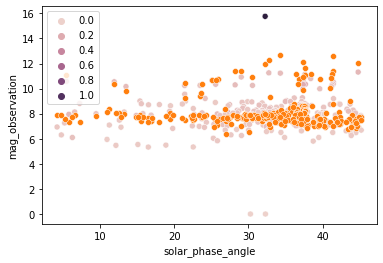

In [9]:
sns.scatterplot(data=data_plot, x="solar_phase_angle", y="mag_observation", hue="e_mag")
sns.scatterplot(data=data_plot, x="solar_phase_angle", y="model_value", markers='s')

In [ ]:
sns.scatterplot(data=data_plot, x="solar_phase_angle", y="mag_plus_error", hue="e_mag")
sns.scatterplot(data=data_plot, x="solar_phase_angle", y="model_value", markers='s')

In [23]:
data_plot.describe()

,solar_phase_angle,range_sat,mag_observation,e_mag,model_value,mag_plus_error,e_mag_model
count,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000
mean,32.255662,1785.864614,7.992630,0.070342,7.930256,8.062972,0.062375
std,9.110461,605.812395,1.402578,0.074573,1.154109,1.440607,1.080223
min,4.231983,197.744684,0.000000,0.000000,6.139739,0.000000,-7.802350
25%,27.978209,1582.692444,7.308367,0.046282,7.363951,7.353946,-0.362963
50%,34.394903,1892.013045,7.965597,0.059496,7.587361,8.015765,0.173826
75%,37.630056,2097.037446,8.569964,0.078210,7.974996,8.622728,0.592156
max,45.210975,3685.082764,15.763537,1.174024,12.491451,16.937561,4.016764


In [ ]:
sns.set_theme(style="darkgrid")
sns.displot(data=data_plot, x="mag_observation", kde=True)

In [24]:
result_fit.describe()

,p_value,mixing_coeffient_est,albedo_est,cross_section_est
count,8.000000,8.000000,8.000000,8.000000
mean,1.234251,0.317875,0.224625,1.018000
std,0.022391,0.234067,0.086295,0.382904
min,1.222540,0.075000,0.119000,0.566000
25%,1.222540,0.126000,0.142000,0.757250
50%,1.222556,0.257000,0.244000,0.901500
75%,1.231645,0.478750,0.301750,1.254250
max,1.280345,0.695000,0.309000,1.581000


In [25]:
result_fit

,p_value,mixing_coeffient_est,albedo_est,cross_section_est
0,1.280345,0.695,0.298,0.566
1,1.258110,0.574,0.190,0.899
2,1.222823,0.447,0.119,0.776
3,1.222571,0.338,0.146,0.701
4,1.222541,0.133,0.304,0.904
5,1.222540,0.105,0.301,1.150
6,1.222540,0.075,0.309,1.567
7,1.222540,0.176,0.130,1.581


In [ ]:
sns.set_theme(style="darkgrid")
sns.displot(data=result_fit, x="cross_section_est", kde=True)

In [ ]:
sns.lineplot(data=result_fit, x="mixing_coeffient_est", y="p_value", markers=True, dashes=False)

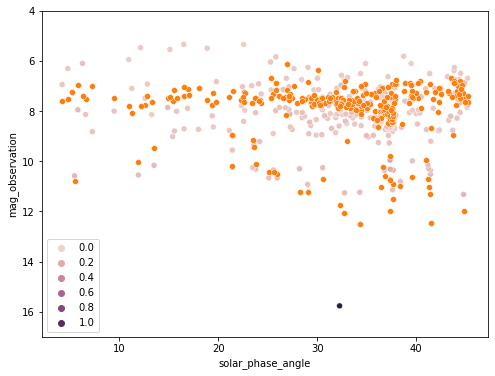

In [26]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=data_plot, x="solar_phase_angle", y="mag_observation", hue="e_mag")
sns.scatterplot(data=data_plot, x="solar_phase_angle", y="model_value", markers='s')
ax.set_ylim(17, 4)
plt.show()

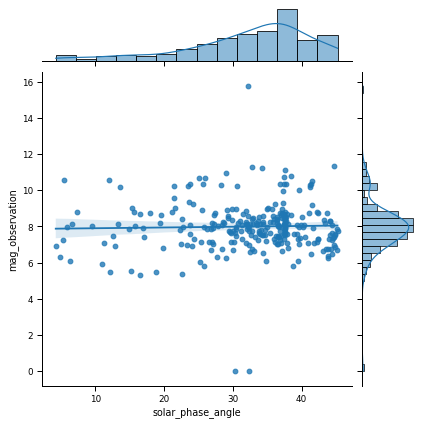

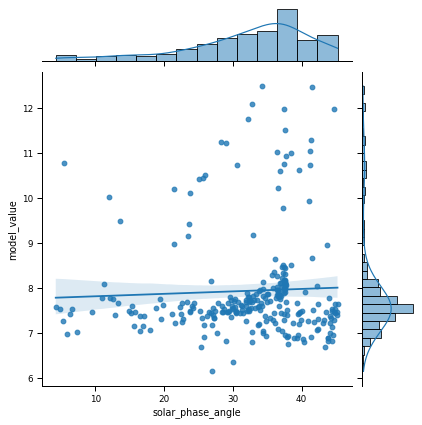

In [39]:

sns.jointplot(data=data_plot, x="solar_phase_angle", y="mag_observation", kind="reg")
sns.jointplot(data=data_plot, x="solar_phase_angle", y="model_value", kind="reg")
sns.set_context("paper")




In [ ]:
sns.scatterplot(data=data_plot, x="mag_observation", col="e_mag_model", row="", hue="e_mag_model",
                binwidth=2, height=1)

In [ ]:
sns.lmplot(x="solar_phase_angle", y="model_value", data=data_plot)